Dataset source:

https://www.kaggle.com/datasets/sanikamal/horses-or-humans-dataset

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras import layers, Model, optimizers, Sequential, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import image_dataset_from_directory, load_img, img_to_array
from tensorflow.data import AUTOTUNE
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [3]:
# Images directory
BASE_DIR = r'D:\datasets\horse-or-human'

train_dir = os.path.join(BASE_DIR, 'train')
validation_dir = os.path.join(BASE_DIR, 'validation')

# Directory with training cat/dog pictures
train_horses_dir = os.path.join(train_dir, 'horses')
train_humans_dir = os.path.join(train_dir, 'humans')

# Directory with validation cat/dog pictures
validation_horses_dir = os.path.join(validation_dir, 'horses')
validation_humans_dir = os.path.join(validation_dir, 'humans')


print(f"Contents of base directory: {os.listdir(BASE_DIR)}")

print(f"\nContents of train directory: {train_dir}")

print(f"\nContents of validation directory: {validation_dir}")

Contents of base directory: ['train', 'validation']

Contents of train directory: D:\datasets\horse-or-human\train

Contents of validation directory: D:\datasets\horse-or-human\validation


In [8]:
# File names in images directory
train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)

print(f"5 files in horses subdir: {train_horses_fnames[:5]}")
print(f"5 files in humans subdir: {train_humans_fnames[:5]}")

5 files in horses subdir: ['horse01-0.png', 'horse01-1.png', 'horse01-2.png', 'horse01-3.png', 'horse01-4.png']
5 files in humans subdir: ['human01-00.png', 'human01-01.png', 'human01-02.png', 'human01-03.png', 'human01-04.png']


In [9]:
# Number of images
print(f'total training horse images: {len(os.listdir(train_horses_dir))}')
print(f'total training human images: {len(os.listdir(train_humans_dir))}')

print(f'total validation horse images: {len(os.listdir(validation_horses_dir))}')
print(f'total validation human images: {len(os.listdir(validation_humans_dir))}')

total training horse images: 500
total training human images: 500
total validation horse images: 128
total validation human images: 128


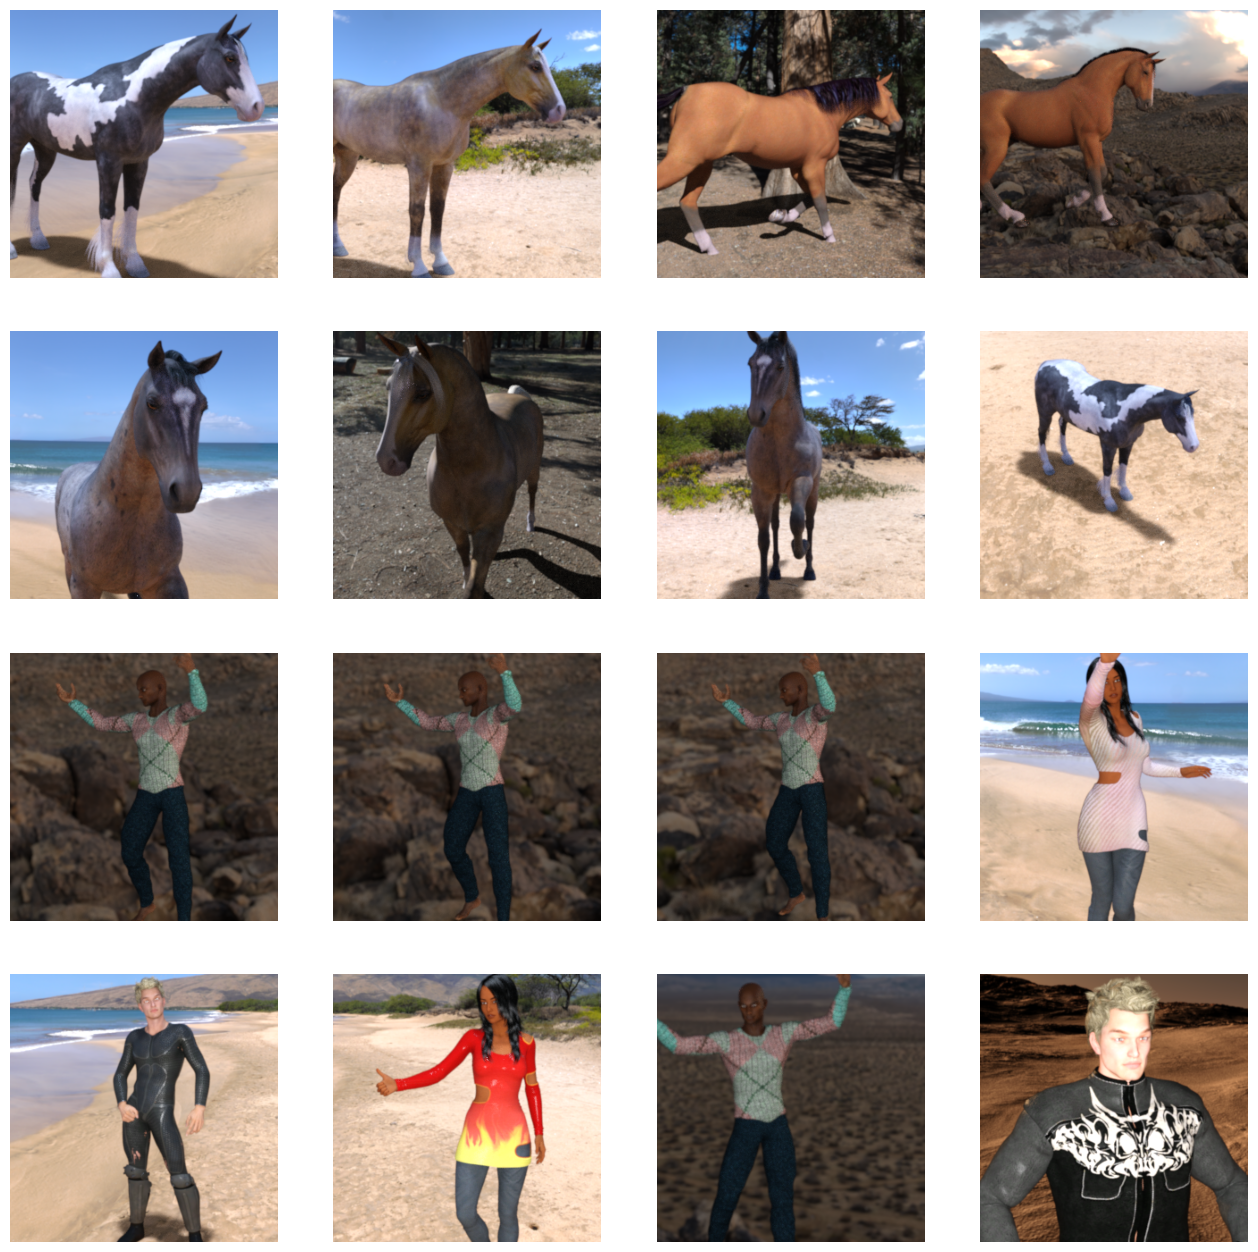

In [13]:
# Image examples
nrows = 4
ncols = 4

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

next_horse_pix = [os.path.join(train_horses_dir, fname)
                for fname in random.sample(train_horses_fnames, k=8)]

next_human_pix = [os.path.join(train_humans_dir, fname)
                for fname in random.sample(train_humans_fnames, k=8)]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
    # Set up subplot; subplot indices start at week_1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [14]:
# Data Preprocessing
# Instantiate the Dataset object for the training set
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(150, 150),
    batch_size=20,
    label_mode='binary')

# Instantiate the Dataset object for the validation set
validation_dataset = image_dataset_from_directory(
    validation_dir,
    image_size=(150, 150),
    batch_size=20,
    label_mode='binary')

Found 1000 files belonging to 2 classes.
Found 256 files belonging to 2 classes.


In [15]:
# Optimizing the datasets for training and validation
'''
cache() stores elements in memory as you use them so it will be faster to retrieve if you need them again
shuffle(), as the name suggests, shuffles the dataset randomly. A buffer_size of 1000 means it will first select a sample from the first week_1,000 elements, then keep filling this buffer until all elements have been selected.
prefetch() gets elements while the model is training so it's faster to feed in new data when the current training step is finished. A buffer_size set to tf.data.AUTOTUNE dynamically sets the number of elements to prefetch during runtime.
'''

SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = AUTOTUNE

train_dataset_final = train_dataset.cache().shuffle(SHUFFLE_BUFFER_SIZE).prefetch(PREFETCH_BUFFER_SIZE)
validation_dataset_final = validation_dataset.cache().prefetch(PREFETCH_BUFFER_SIZE)

### Model

In [16]:
# Pre-trained model
# Set the weights file you downloaded into a variable
local_weights_file = r'D:\Python things\middle-ml-cv-roadmap\data\raw/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(
    input_shape = (150, 150, 3),
    include_top = False,
    weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
    layer.trainable = False

In [17]:
pre_trained_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 150, 150, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 74, 74, 32)        │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 74, 74, 32)        │              96 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 74, 74, 32)        │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 72, 72, 32)        │           9,216 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 72, 72, 32)        │              96 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 72, 72, 32)        │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 72, 72, 64)        │          18,432 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 72, 72, 64)        │             192 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 72, 72, 64)        │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 35, 35, 64)        │               0 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 35, 35, 80)        │           5,120 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 35, 35, 80)        │             240 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 35, 35, 80)        │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 33, 33, 192)       │         138,240 │ activation_3[0][0]         │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [18]:
# Choose `mixed7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output.shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [19]:
# Dense layers for classifier
# Flatten the output layer to week_1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with week_1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)

# Append the dense network to the base model
model = Model(pre_trained_model.input, x)

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 150, 150, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 74, 74, 32)        │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 74, 74, 32)        │              96 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 74, 74, 32)        │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 72, 72, 32)        │           9,216 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 72, 72, 32)        │              96 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 72, 72, 32)        │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 72, 72, 64)        │          18,432 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 72, 72, 64)        │             192 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 72, 72, 64)        │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 35, 35, 64)        │               0 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 35, 35, 80)        │           5,120 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 35, 35, 80)        │             240 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 35, 35, 80)        │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 33, 33, 192)       │         138,240 │ activation_3[0][0]         │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 47,512,481 (181.25 MB)

 Trainable params: 38,537,217 (147.01 MB)

 Non-trainable params: 8,975,264 (34.24 MB)

In [20]:
# Augmentation layers
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.4),
    layers.RandomTranslation(0.2,0.2),
    layers.RandomContrast(0.4),
    layers.RandomZoom(0.2)])

In [21]:
# Final model
inputs = Input(shape=(150, 150, 3))
x = data_augmentation(inputs)
x = model(x)

model_with_aug = Model(inputs, x)

In [23]:
model.compile(
    optimizer=optimizers.RMSprop(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics = ['accuracy'])

In [24]:
early_stop = EarlyStopping(
    monitor="val_loss",       # what to monitor
    patience=3,               # epochs to wait without improvement
    restore_best_weights=True)# roll back to best epoch

checkpoint = ModelCheckpoint(
    filepath="07_hm_classification_model.keras",
    monitor="val_loss",
    save_best_only=True)

history = model.fit(
    train_dataset_final,
    epochs=100,
    validation_data=validation_dataset_final,
    callbacks=[early_stop, checkpoint],
    verbose=2)

Epoch 1/100
50/50 - 20s - 409ms/step - accuracy: 0.7190 - loss: 6.1480 - val_accuracy: 0.7852 - val_loss: 3.9869
Epoch 2/100
50/50 - 15s - 290ms/step - accuracy: 0.8520 - loss: 2.1901 - val_accuracy: 0.9219 - val_loss: 2.7787
Epoch 3/100
50/50 - 15s - 294ms/step - accuracy: 0.8830 - loss: 1.9404 - val_accuracy: 0.9297 - val_loss: 1.8550
Epoch 4/100
50/50 - 12s - 246ms/step - accuracy: 0.9260 - loss: 0.8296 - val_accuracy: 0.9258 - val_loss: 3.4913
Epoch 5/100
50/50 - 12s - 246ms/step - accuracy: 0.9280 - loss: 1.0150 - val_accuracy: 0.9453 - val_loss: 1.8881
Epoch 6/100
50/50 - 14s - 289ms/step - accuracy: 0.9360 - loss: 0.7966 - val_accuracy: 0.9414 - val_loss: 1.7695
Epoch 7/100
50/50 - 15s - 290ms/step - accuracy: 0.9620 - loss: 0.4456 - val_accuracy: 0.9258 - val_loss: 1.6216
Epoch 8/100
50/50 - 12s - 244ms/step - accuracy: 0.9470 - loss: 0.6775 - val_accuracy: 0.9336 - val_loss: 2.9280
Epoch 9/100
50/50 - 13s - 261ms/step - accuracy: 0.9640 - loss: 0.4295 - val_accuracy: 0.9375 - 

In [25]:
def plot_history(history):
    """
    Plots the training and validation loss and accuracy from a Keras history object.

    Args:
        history (dict): The history.history dictionary returned by model.fit().
    """

    # Determine which keys to use for loss and accuracy
    # Keras uses 'accuracy'/'val_accuracy' or 'acc'/'val_acc'
    if 'accuracy' in history:
        acc_key = 'accuracy'
        val_acc_key = 'val_accuracy'
    elif 'acc' in history:
        acc_key = 'acc'
        val_acc_key = 'val_acc'
    else:
        print("Could not find accuracy/acc keys in history.")
        return

    # Get the number of epochs
    epochs = range(1, len(history['loss']) + 1)
    
    # week_1. Plot Training and Validation Loss
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['loss'], 'b', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 2. Plot Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history[acc_key], 'b', label='Training Accuracy')
    plt.plot(epochs, history[val_acc_key], 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout() # Adjusts plot to prevent overlap
    plt.show()

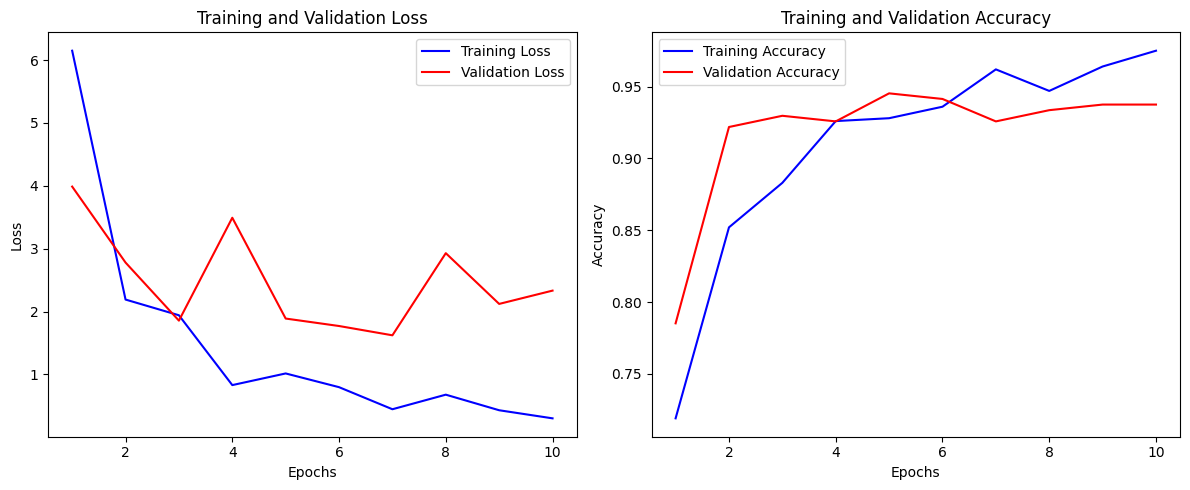

In [26]:
plot_history(history.history)